# Современные методы анализа данных и машинного обучения, БИ

## НИУ ВШЭ, 2023-24 учебный год

# Семинар 16. Решающие деревья и случайный лес


Сегодня на семинаре мы с вами попрактикуемся с новыми, рассмотренными на лекции моделями машинного обучения — решающими деревьями и случайным лесом. Делать мы это будем в рамках задачи регрессии на датасете [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality). Данный датасет содержит в себе химические характеристики различных вин и оценку, которую выставляет вину комиссия из нескольких сомелье.

Процесс оценки вин — это долгий, дорогостоящий и часто неточный процесс, ведь в разных комиссиях будут сидеть разные люди, их может быть разное количество и они могут иметь разные предпочтения. Мотивация к реализации нашей задачи с предметной точки зрения заключается в следующем: хочется собрать достаточно точные данные оценок (достичь этого можно тем, что будет собрана очень большая комиссия, в которой ответы экспертов усреднятся) и построить алгоритм, который сможет давать рекомендации к оценки вина без необходимости собирать большие комиссии, что сэкономит нам много денег и сгладит личные предпочтения отдельных экспертов.

## Описание данных

Итак, мы уже выяснили с вами, что наш датасет содержит в себе описания вин. Данное описание реализуется засчёт 11 различных признаков, представляющих собой параметры вина — результаты обычных физико-химических тестов напитка:

* 1 — Фиксированная кислотность
* 2 — Летучая кислотность
* 3 — Содержание лимонной кислоты
* 4 — Остаточный сахар
* 5 — Содержание хлоридов
* 6 — Содержание свободного диоксида серы
* 7 — Общее содержание диоксида серы
* 8 — Плотность
* 9 — Кислотность pH
* 10 — Содержание сульфатов
* 11 — Градус алкоголя

Двенадцатым столбцом является непосредственно сама целевая переменная:
* 12 - Качество (оценка в диапазоне от 0 до 10)


In [ ]:
# Импортируем наши стандартные библиотеки
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

Загрузим данные при помощи `read_csv` по ссылке: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

Не забываем об аргументе-разделителе `sep`.

In [ ]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")

Проверим, что все загрузилось верно, выведя случайные строчки датасета, и посмотрим на сами данные:

In [ ]:
df.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
286,12.0,0.45,0.55,2.0,0.073,25.0,49.0,0.99970,3.10,0.76,10.3,6
1143,7.0,0.22,0.30,1.8,0.065,16.0,20.0,0.99672,3.61,0.82,10.0,6
703,7.5,0.38,0.48,2.6,0.073,22.0,84.0,0.99720,3.32,0.70,9.6,4
1580,7.4,0.35,0.33,2.4,0.068,9.0,26.0,0.99470,3.36,0.60,11.9,6
586,11.1,0.31,0.49,2.7,0.094,16.0,47.0,0.99860,3.12,1.02,10.6,7
1053,8.3,0.33,0.42,2.3,0.070,9.0,20.0,0.99426,3.38,0.77,12.7,7
470,13.0,0.32,0.65,2.6,0.093,15.0,47.0,0.99960,3.05,0.61,10.6,5
926,9.4,0.24,0.33,2.3,0.061,52.0,73.0,0.99786,3.47,0.90,10.2,6
733,7.0,0.45,0.34,2.7,0.082,16.0,72.0,0.99800,3.55,0.60,9.5,5
193,7.6,0.55,0.21,2.2,0.071,7.0,28.0,0.99640,3.28,0.55,9.7,5


Всё отлично!

## Подготовка данных

Для начала давайте проверим, есть ли в наших данных пропуски, а заодно посмотрим на типы признаков при помощи метода `info`.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Уже видно, что у нас в датасете нет пропусков и все данные являются числовыми, что, конечно, значительно упрощает нашу дальнейшую работу с ними.

Перед тем как переходить к обучению модели, посмотрим еще на статистики каждого признака, воспользовавшись методом `describe`.

In [ ]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Особое внимание следует уделить также целевой переменной. Давайте отдельно посмотрим на нее, отобразив уникальные значения столбца (`unique`) и построив гистограмму распределения (`hist`).

In [ ]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

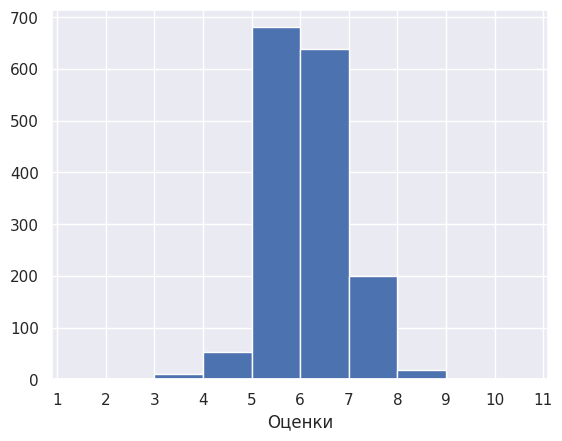

In [ ]:
df['quality'].hist(bins = np.arange(1, 12))

plt.xlabel("Оценки")
plt.xticks(np.arange(1, 12))
plt.xlim(0.9, 11.1)
plt.show()

Какие можно сделать выводы?

Разделим теперь данные на признаки и таргет, а также на обучение и тест при помощи знакомой нам функции `train_test_split`.

Несмотря на то что мы имеем дело с задачей регрессии, а не классификации, воспользуемся стратификацией по таргету, поскольку природа данных нам это позволяет.


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["quality"])
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

Посмотрим на размеры получившегося обучающего датасета и на сами данные, чтобы убедиться, что всё было сделано корректно.


In [ ]:
X_train.shape

(1199, 11)

In [ ]:
X_train.head(7)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
990,7.7,0.39,0.12,1.7,0.097,19.0,27.0,0.99596,3.16,0.49,9.4
754,7.8,0.48,0.68,1.7,0.415,14.0,32.0,0.99656,3.09,1.06,9.1
1137,10.4,0.52,0.45,2.0,0.080,6.0,13.0,0.99774,3.22,0.76,11.4
765,9.2,0.67,0.10,3.0,0.091,12.0,48.0,0.99888,3.31,0.54,9.5
1176,6.5,0.88,0.03,5.6,0.079,23.0,47.0,0.99572,3.58,0.50,11.2
545,9.1,0.47,0.49,2.6,0.094,38.0,106.0,0.99820,3.08,0.59,9.1
1565,6.7,0.67,0.02,1.9,0.061,26.0,42.0,0.99489,3.39,0.82,10.9


Всё хорошо!

Перед тем как переходить непосредственно к машинному обучению, давайте ещё построим график зависимости оценки вина от каждого из признаков на обучающей части. Данный график позволит нам сформировать какие-то первичные инсайты и гипотезы относительно данных, целевой переменной и зависимостей — что в идеале и предполагается в рамках этапа EDA.

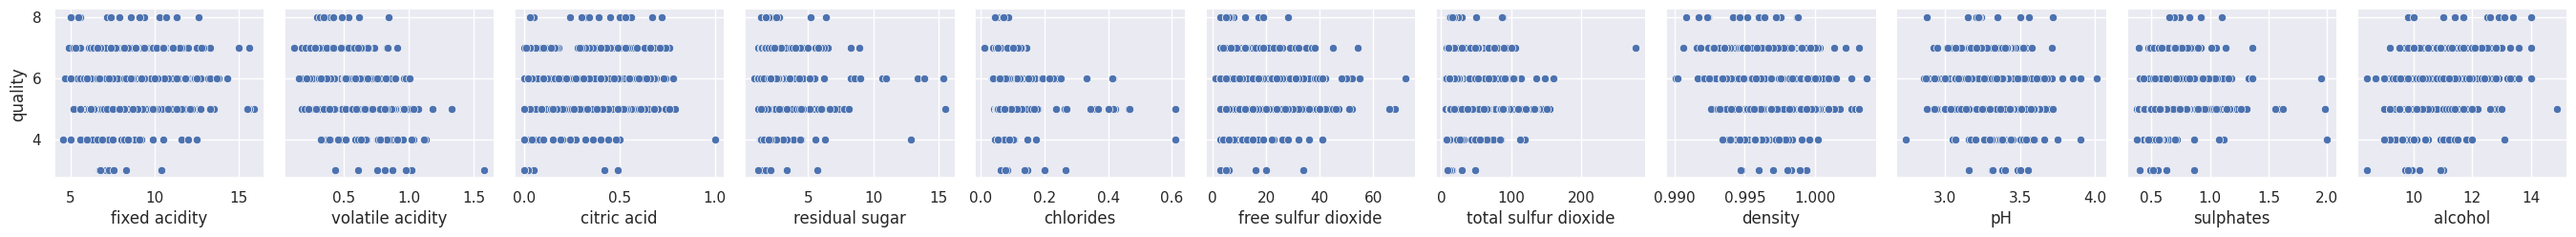

In [ ]:
X_train_plot = deepcopy(X_train)
X_train_plot["quality"] = y_train

sns.pairplot(
    X_train_plot,
    x_vars=X_train.columns,
    y_vars=["quality"],
)

plt.show()

Какие инсайты можно выделить уже сейчас?

## Дерево решений

Прежде чем переходить к построению модели, необходимо определиться с тем, какими метриками мы будем оценивать работу нашего алгоритма.

Конкретно в нашей задаче предлагается использовать метрики `max_error` и `mean_absolute_error`. Что показывают данные метрики?


In [ ]:
from sklearn.metrics import max_error, mean_absolute_error

Сегодня мы с вами работаем с деревом решений, которое подробно разбирали на лекции. По ссылке доступна [документация алгоритма](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) по его реализации из библиотеки `sklearn`.

Зафиксируем `seed` и импортируем класс `DecisionTreeRegressor` из модуля `tree` библиотеки `sklearn`.

In [ ]:
np.random.seed(2023)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Для начала давайте построим бейзлайн-модель дерева решений.

### Задание для самостоятельного решения (обучение Decision Tree)

Обучите модель DecisionTree. Для обучения используйте стандартный интерфейс моделей машинного обучения из библиотеки `sklearn`.

На выходе получите предсказания на обучающем и тестовом датасете.

In [ ]:
# your code here

# y_DTR_train_predict = ...
# y_DTR_test_predict = ...

Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма:

In [ ]:
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_DTR_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_DTR_train_predict)}")
print("\nTEST")
print(f"MAX ERROR: {max_error(y_test, y_DTR_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_DTR_test_predict)}")

TRAIN
MAX ERROR: 0.0
MAE:       0.0

TEST
MAX ERROR: 4.0
MAE:       0.4275


Какие выводы вы можете сделать, глядя на значения полученных метрик?

Итак, мы видим, что, поскольку мы не ограничили глубину дерева, алгоритм сильнейшим образом переобучился на обучающей выборке, подстроившись под абсолютно каждый пример и получив нулевую ошибку.

Давайте повторим тот же самый пайплайн, но ограничив глубину дерева.

Что нужно изменить для этого в коде выше?

In [ ]:
# Создадим объект класса DecisionTreeRegressor с max_depth равной, например, 5
DTR = DecisionTreeRegressor(max_depth=5)

# Обучим его на обучающей части датасета при помощи метода fit
DTR.fit(X_train, y_train)

# Получим предсказание нашего дерева при помощи метода predict на обучающем и тестовом датасете
y_DTR_train_predict = DTR.predict(X_train)
y_DTR_test_predict = DTR.predict(X_test)

# Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_DTR_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_DTR_train_predict)}")
print("\nTEST")
print(f"MAX ERROR: {max_error(y_test, y_DTR_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_DTR_test_predict)}")

TRAIN
MAX ERROR: 2.2442396313364057
MAE:       0.44966863366049636

TEST
MAX ERROR: 3.0
MAE:       0.5042198927897623


Так, ситуация уже лучше, но достаточно очевидно, что мы пока ещё далеки от идеала. В принципе, фронт дальнейших действий понятен: мы с вами попробовали как-то ограничить максимальную глубину дерева (`max_depth`) и взяли первое попавшееся значение в качестве этого гиперпараметра модели. Но ведь, наверняка, существуют другие значения максимальной глубины, для которых метрики качества получатся еще лучше (а возможно и даже очень значительно лучше). То есть выходит, что нам нужно сидеть и честно перебирать значения, пытаясь найти подходящую максимальную глубину.

Однако у дерева ведь не только один гиперпараметр. Есть, например, такой настраиваемый параметр как `min_samples_leaf`, который также позволяет бороться с переобучением, но не такой радикальный как `max_depth`. И его тоже желательно бы настроить...

Итого, получается, что у нас есть как минимум два гиперпараметра, которые мы очень хотели бы оптимизировать, чтобы повысить качество нашего алгоритма, но пока что, к сожалению, не очень имеем представление о том, как это лучше всего реализовать.

В принципе, первая идея приходит в голову достаточно быстро: можно просто запустить два вложенных цикла, чтобы перебрать все возможные варианты наборов гиперпараметров и выбрать из всех наилучший по качеству. Но дело в том, что, как вы, наверное, догадываетесь, циклы в Python — это далеко не самая оптимизированная история: они довольно медленные, плюс по умолчанию не выполняются параллельно; ну а кроме того, в таком случае вам бы отдельно пришлось писать дополнительные функции для отслеживания качества алгоритма.

На наше счастье, нам не придется всем этим заниматься, поскольку в `sklearn` уже реализован специальный функционал для такой задачи, причем — довольно эффективный!

### Кросс-валидация

Ещё на самой первой лекции по машинному обучению мы с вами обсуждали такое прекрасное понятие, как кросс-валидация. Что же она собой представляет?


Кросс-валидация, которая помогает нам получить автоматизированным образом большое количество валидационных выборок (напомним, что валидационная выборка — это нечто среднее между тренировочной и тестовой), — служит тем самым нашей задаче как автоматический подборщик гиперпараметров. И действительно: мы же можем тестировать различные гиперпараметры в начале как бы внутри тренировочной выборки — подразделяющейся автоматически на train и validation — а затем, найдя то, что работает лучше всего в рамках нее, — уже масштабировать эти оптимальные настройки на всю нашу задачу целиком.

Подобный функционал в `sklearn` реализован с помощью эффективной и распараллеливающейся функции — и правда: мы же можем перебирать все комбинации гиперпараметров одновременно, не дожидаясь, пока доработает одна, чтобы начинать тестировать другую, — которая называется `GridSearchCV`.

Импортируем `GridSearchCV` из модуля `model_selection` библиотеки `sklearn`.


In [ ]:
from sklearn.model_selection import GridSearchCV

По большому счету, `GridSearchCV` — очень простая сущность. Она позволяет быстро перебирать все возможные комбинации указанных гиперпараметров модели, при этом, как мы сказали, умеет работать в несколько потоков паралелльно, имеет функционал подсчета метрик, кросс-валидации и множество других полезных бонусов, которые позволяют вам быстро и без изобретения велосипедов подобрать оптимальные гиперпараметры вашей модели.

Подробнее о `GridSearchCV` можно прочитать [тут](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).

Итак, воспользуемся функцией `GridSearchCV` для нашей задачи. В качестве метрики определения "лучшей" модели выберем `mean_absolute_error`.

In [ ]:
grid = GridSearchCV(
            DecisionTreeRegressor(),                # Алгоритм, в котором будем подбирать параметры
            param_grid = {                          # Сетка параметров в виде словаря
                'max_depth': range(1, 8),
                'min_samples_leaf': range(1, 8),
            },
            scoring = 'neg_mean_absolute_error',    # Какие метрики будут считаться (кстати, почему "neg_..."?)
            cv = 3,                                 # CV для кросс-валидации (число фолдов или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 8),
                         'min_samples_leaf': range(1, 8)},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=5)

Отлично, мы обучили наш `GridSearch`. Выведем теперь найденный набор лучших параметров (они хранятся в `best_params_`), а также значение метрики для этого набора.

In [ ]:
print(f"Лучшая метрика:   {grid.best_score_}")
print(f"Лучшие параметры: {grid.best_params_}")

Лучшая метрика:   -0.5164372742692473
Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4}


Очень интересно! Давайте теперь получим предсказание нашего лучшего дерева (оно хранится в `best_estimator_` — как видите, всё в одном месте) при помощи метода `predict` на обучающем и тестовом датасете. Также посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма.


In [ ]:
y_GS_train_predict = grid.best_estimator_.predict(X_train)
y_GS_test_predict = grid.best_estimator_.predict(X_test)

print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_GS_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_GS_train_predict)}")
print("\nTEST")
print(f"MAX ERROR: {max_error(y_test, y_GS_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_GS_test_predict)}")

TRAIN
MAX ERROR: 2.164835164835165
MAE:       0.4570603831624545

TEST
MAX ERROR: 2.7142857142857144
MAE:       0.5091124681517429


Видим, что метрики действительно улучшились как на обучающем, так и на тестовом датасете. Конечно же, этот процесс улучшения можно и продолжать!

### Отрисовка работы решающего дерева

Модуль `tree` библиотеки `sklearn` имеет функционал для отрисовки дерева решений. Это часто бывает удобно, если хочется понять, почему алгоритм принял то или иное решение. Да и в конце концов, это просто красиво! :)

Импортируем функцию `plot_tree` из модуля `tree` библиотеки `sklearn`


In [ ]:
from sklearn.tree import plot_tree

Нарисуем наше то, последнее лучшее дерево из сетки.


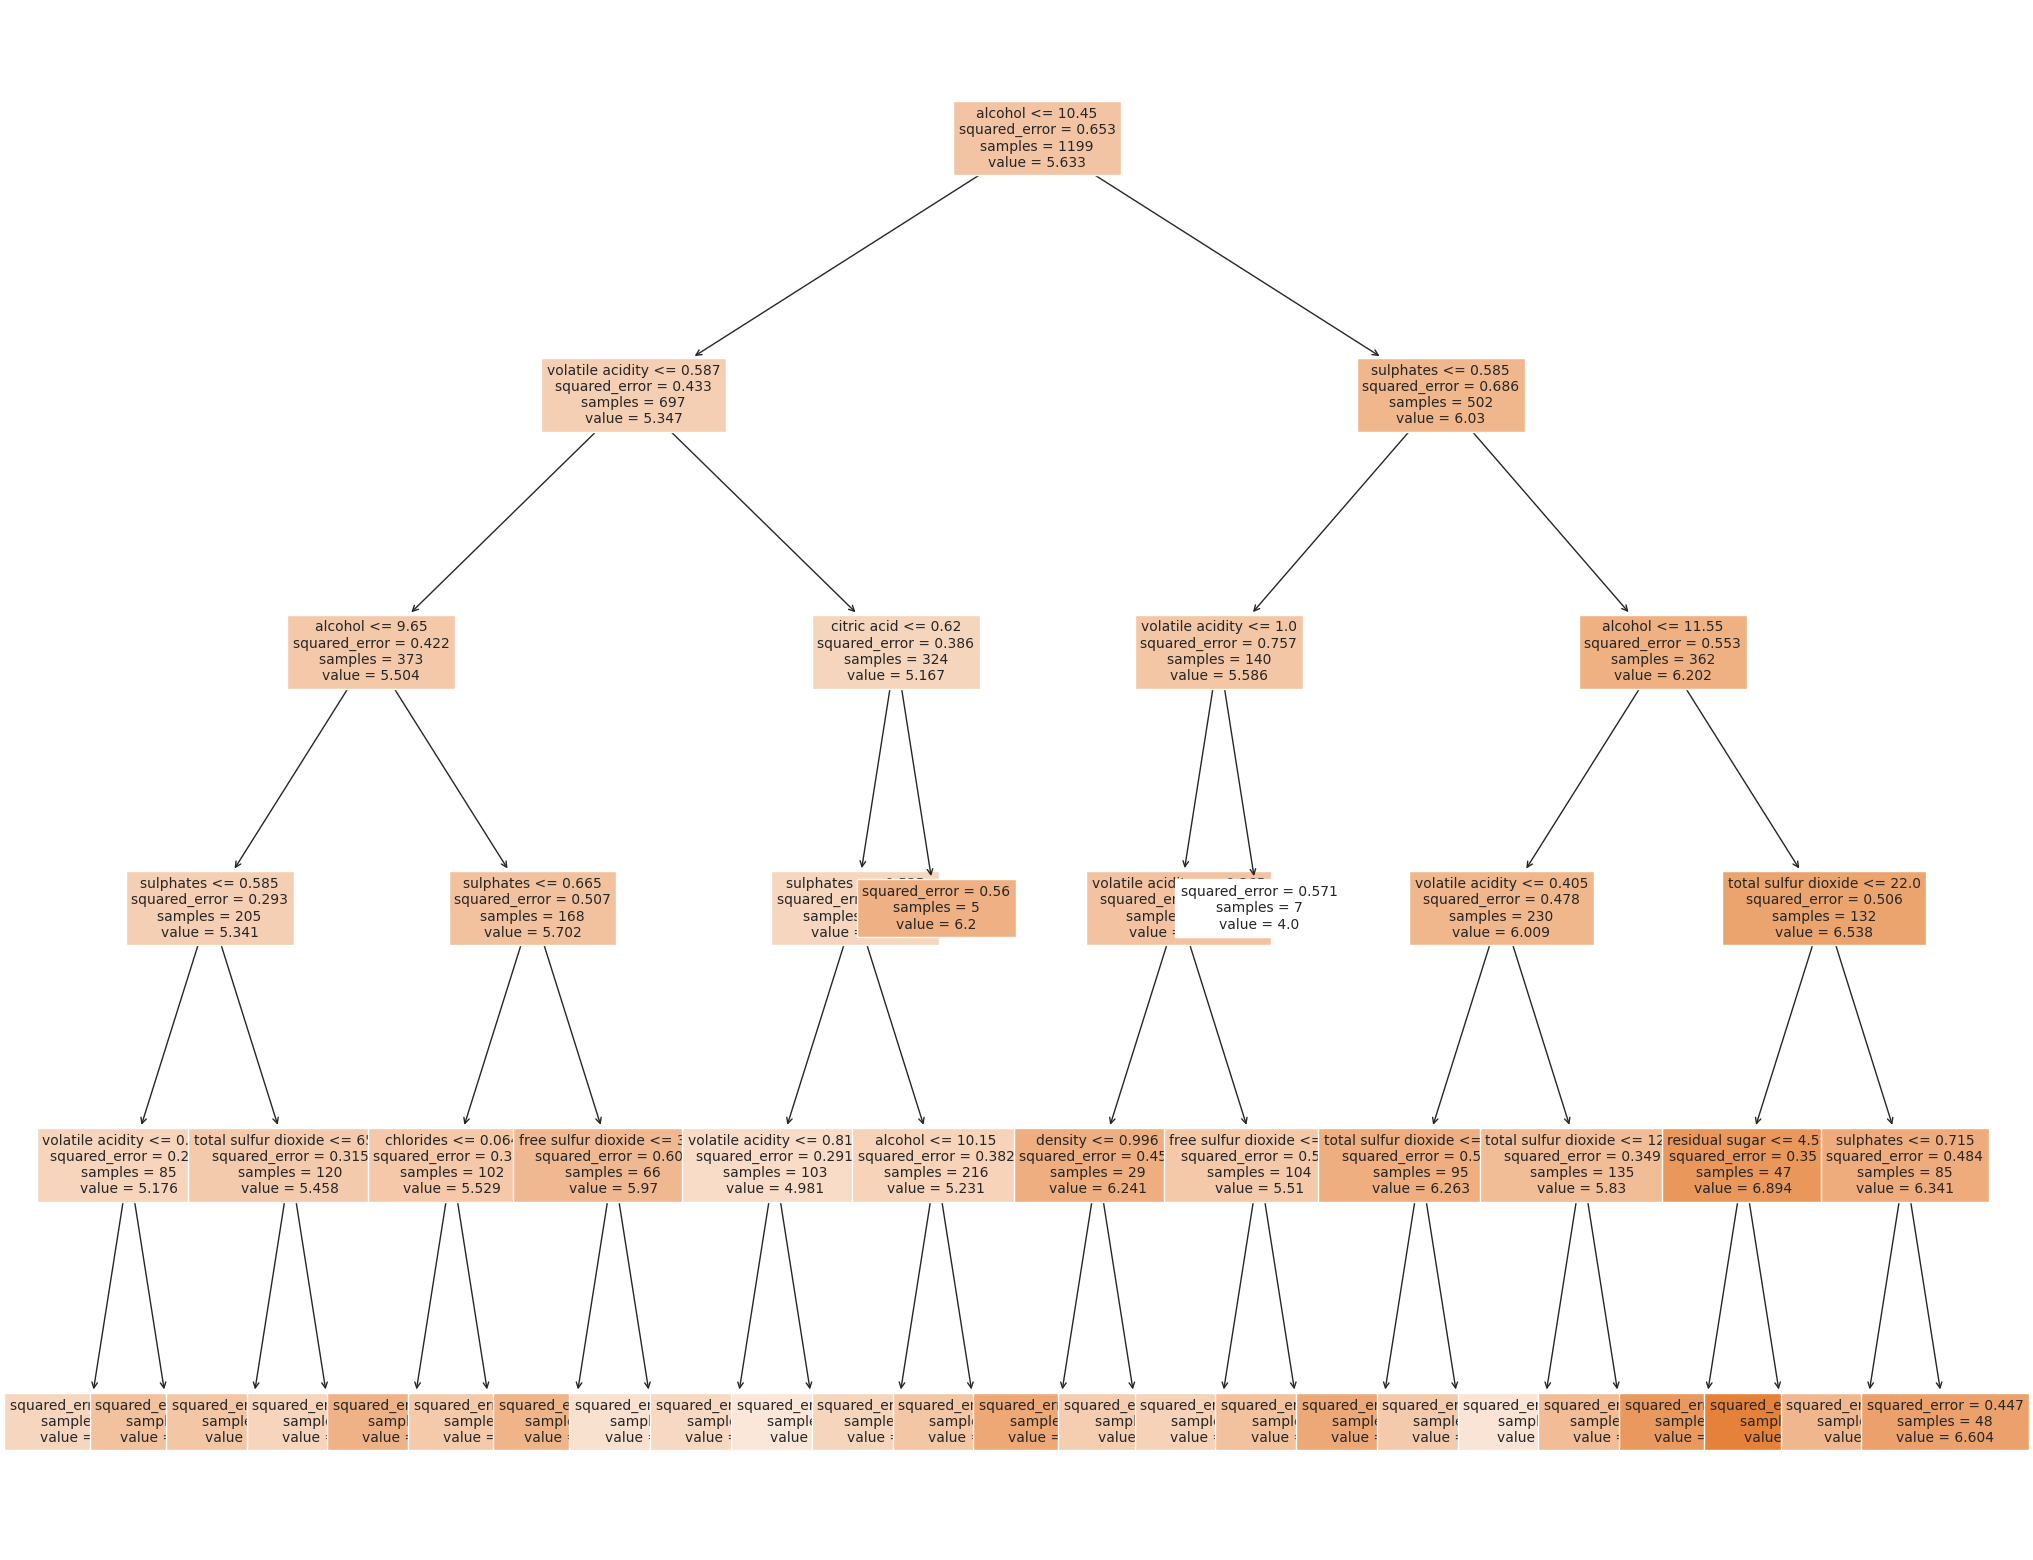

In [ ]:
fig = plt.figure(figsize=(25,20))

_ = plot_tree(
        grid.best_estimator_,
        feature_names = X_train.columns,
        class_names = y_train.name,
        filled = True,
        fontsize = 10
    )

К сожалению, из-за того, что у нас большая глубина, на дереве видно не все, но это можно настроить, поигравшись с размером картинки и шрифтом.



#### Вопрос

Какие выводы мы можем сделать, глядя на наше дерево?

## Случайный лес

Давайте теперь реализуем другую модель машинного обучения, которую мы также подробно обсуждали на лекции: Random Forest, или Случайный лес.

С технической документацией алгоритма можно ознакомиться [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

Импортируем класс `RandomForestRegressor` из модуля `ensemble` библиотеки `sklearn`


In [ ]:
from sklearn.ensemble import RandomForestRegressor

Построим бейзлайн модели случайного леса:

In [ ]:
# Создадим объект класса RandomForestRegressor с параметрами по умолчанию
np.random.seed(2023)
RFR = RandomForestRegressor(min_samples_split=2, max_features=6, max_depth=21)

# Обучим его на обучающей части датасета при помощи метода fit
RFR.fit(X_train, y_train)

RandomForestRegressor(max_depth=21, max_features=6)

Получим предсказание нашего случайного леса при помощи метода `predict` на обучающем и тестовом датасете:


In [ ]:
y_RFR_train_predict = RFR.predict(X_train)
y_RFR_test_predict = RFR.predict(X_test)

Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма


In [ ]:
print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_RFR_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_RFR_train_predict)}")
print("\nTEST")
print(f"MAX ERROR: {max_error(y_test, y_RFR_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_RFR_test_predict)}")

TRAIN
MAX ERROR: 1.0499999999999998
MAE:       0.15895566931994987

TEST
MAX ERROR: 2.3899999999999997
MAE:       0.39079237003968254


Что можно сказать, глядя на такие значения метрик?

Мы видим, что результаты получились на голову выше обычного дерева решений, но также можно заметить, что у нас имеет место переобучение.

### Подбор гиперпараметров при помощи Randomized Search

Итак, давайте вспомним, какие гиперпараметры есть у случайного леса, и поймем, какие из них нужно оптимизировать.

У нас есть:

* Число деревьев в лесе (`n_estimators`) — этот параметр просто нужно выбрать достаточно большим.
* Максимальное число признаков у дерева (`max_features`) — это самый важный параметр, его точно нужно подбирать.
* Максимальная глубина деревьев (`max_depth`) — желательно не ограничивать, но это очень ресурсоемко, поэтому нужно подобрать достаточно глубокие, но все же органиченные деревья.
* Минимальное число объектов в вершине для расщепления (`min_samples_split`) — тоже важный параметр, подбирается исходя из данных.

Таким образом, у нас есть сложный алгоритм (в `n_estimators` раз сложнее обычного решающего дерева) и 3 гиперпараметра для подбора. Даже с быстрым `GridSearchCV` это будет долго. Поэтому мы воспользуемся его братом-близнецом `RandomizedSearchCV`, который перебирает не все возможные комбинации, а лишь некоторое заданное число случайных.

Подробнее о `RandomizedSearchCV` можно прочитать [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV).

Импортируем `RandomizedSearchCV` из модуля `model_selection` библиотеки `sklearn`


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

И воспользуемся функцией `RandomizedSearchCV` для нашей задачи. В качестве метрики определения "лучшей" модели выберем `mean_absolute_error`.

In [ ]:
np.random.seed(2023)
grid = RandomizedSearchCV(
            RandomForestRegressor(),                # Алгоритм, в котором будем подбирать параметры
            param_distributions = {                 # Сетка параметров в виде словаря
                'max_depth': range(6, 20),
                'min_samples_split': range(2, 9),
                'max_features': range(2, 11)
            },
            scoring = 'neg_mean_absolute_error',    # Какие метрики будут считаться
            cv = 6,                                 # CV для кросс-валидации (число фолдов или индексы)
            n_jobs = -1,                            # Число используемых ядер для работы
            return_train_score = True,              # Считать ли метрики на обучающей части
            n_iter=16,                              # Число итераций (сколько будем брать случайных наборов)
            verbose = 5,                            # Чем больше, тем алгоритм разговорчивее
        )

# Обучим сетку на обучающем датасете при помощи метода fit
grid.fit(X_train, y_train)

Fitting 6 folds for each of 16 candidates, totalling 96 fits


RandomizedSearchCV(cv=6, estimator=RandomForestRegressor(), n_iter=16,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(6, 20),
                                        'max_features': range(2, 11),
                                        'min_samples_split': range(2, 9)},
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=5)

Выведем найденный набор лучших параметров (они хранятся в `best_params_`), а также значение метрики для этого набора.

In [ ]:
print(f"Лучшая метрика:   {grid.best_score_}")
print(f"Лучшие параметры: {grid.best_params_}")

Лучшая метрика:   -0.4440694357295422
Лучшие параметры: {'min_samples_split': 2, 'max_features': 4, 'max_depth': 19}


Как можно видеть, `max_depth` выбрана максимальной, но действительно — ведь так и строится случайный лес :)

Мы в этом еще раз убедились!

Получим предсказание нашего лучшего дерева (хранится в `best_estimator_`) при помощи метода `predict` на обучающем и тестовом датасете. Посмотрим на наши метрики на обучении и тесте и проанализирем работу алгоритма


In [ ]:
y_GS_train_predict = grid.best_estimator_.predict(X_train)
y_GS_test_predict = grid.best_estimator_.predict(X_test)

print("TRAIN")
print(f"MAX ERROR: {max_error(y_train, y_GS_train_predict)}")
print(f"MAE:       {mean_absolute_error(y_train, y_GS_train_predict)}")
print("\nTEST")
print(f"MAX ERROR: {max_error(y_test, y_GS_test_predict)}")
print(f"MAE:       {mean_absolute_error(y_test, y_GS_test_predict)}")

TRAIN
MAX ERROR: 1.0999999999999996
MAE:       0.15940683330424413

TEST
MAX ERROR: 2.42
MAE:       0.3915743906734862


Какие выводы можно сделать?

Видим, что ошибка немного уменьшилась (на самом деле, просто параметры по умолчанию были достаточно хороши), однако мы не смогли полностью избавиться от переобучения. Что мы можем сделать с этим? Какие параметры нужно настроить?

Ниже вы проверите ваши гипотезы! :)

### Творческое задание (улучшение качества алгоритма)

Поэксперементируйте с предобработкой данных, моделями и гиперпараметрами моделей. Попробуйте получить качество выше, чем то, что получили мы с вами вместе. В качестве метрик scor'a используйте также `MAE` и `Max Error`. Не используйте модели машинного обучения и сложные фичи, которые мы не разбирали в рамках нашего курса — поэксперементируйте с тем, что мы обсуждали. Поверьте, там есть достаточное поле для улучшений.

Не забудьте фиксировать случайный сид: `np.random.seed(2023)` — чтобы результаты были сравнимыми.

Топ лучших студентов по метрикам качества получат плюсы за работу!

In [ ]:
# your code here